In [72]:
# from __future__ import print_function

import pandas as pd 
import numpy as np 
import sklearn

# NLTK/NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Classifiers 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
import sklearn.decomposition as decomposition

#Sampling
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")

import csv
import pickle
%run my_functions.ipynb

## Load Previously Cleaned Dataset

In [3]:
with open('data/cleaned-reshuffled.pkl', 'rb') as f:
	df = pickle.load(f)

In [4]:
df.head()

,id,label,tweet,tidy_tweet,no_hash_tweet,tokenized_tweet,stemmed_tokens,lemmatized_tokens,lem_tweet,stem_tweet
0,29727,0,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre engrus ...,"[sad, to, see, the, scenes, of, hooligans, pre...","[sad, to, see, the, scene, of, hooligan, pre, ...","[sad, to, see, the, scene, of, hooligan, pre, ...",sad to see the scenes of hooligans pre engrus ...,sad to see the scenes of hooligans pre engrus ...
1,14466,0,#gooddyeyoung #yoyoyo !! super happy to be ap...,#gooddyeyoung #yoyoyo super happy to be apa of...,gooddyeyoung yoyoyo super happy to be apa of t...,"[gooddyeyoung, yoyoyo, super, happy, to, be, a...","[gooddyeyoung, yoyoyo, super, happi, to, be, a...","[gooddyeyoung, yoyoyo, super, happy, to, be, a...",gooddyeyoung yoyoyo super happy to be apa of t...,gooddyeyoung yoyoyo super happy to be apa of t...
2,18194,0,queen evil's bihdayð#lnic #lnicjustanevilbd...,queen evil s bihday #lnic #lnicjustanevilbday ...,queen evil s bihday lnic lnicjustanevilbday bi...,"[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...",queen evil s bihday lnic lnicjustanevilbday bi...,queen evil s bihday lnic lnicjustanevilbday bi...
3,18283,1,@user you might be a libtard if... #libtard #...,you might be a libtard if #libtard #sjw #liber...,you might be a libtard if libtard sjw liberal ...,"[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...",you might be a libtard if libtard sjw liberal ...,you might be a libtard if libtard sjw liberal ...
4,25845,0,what are your goals? find out here... #smile...,what are your goals find out here #smile,what are your goals find out here smile,"[what, are, your, goals, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]",what are your goals find out here smile,what are your goals find out here smil


## Split Data into Train, Validation and Test Sets:

In [5]:
X = df.drop(['label'], axis = 1)

In [6]:
y = df['label']

In [7]:
y.value_counts(normalize = True)

0    0.929854
1    0.070146
Name: label, dtype: float64

In [8]:
#splitting into train and test 
X_model, X_test, y_model, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state=123)

In [9]:
#splitting "model" into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, stratify = y_model, test_size=0.20, random_state=123)

## Tuning and Testing Classifier Performance:

Seven classifiers (Multinomial Naive Bayes, Support Vector Machine, Logistic Regression, Random Forest, XGBooster, and a Recurrent Neural Network) were trained and their performance was compared in the initial model testing phase. As applicable, the performance of each classifier was compared using various techniques for:

- text cleaning: tokenizing, stemming and lemmatizing
- correcting for class imbalance (oversampling, undersampling, SMOTE and class weights)
- text vectorization methods - count vectorizer and tfidf vectorizer with a range from 1-3 n-grams
- word embedding methods - Word2Vec and GLoVe

Logistic Regression had the best F1 performance from the early testing and model comparison phase.  Tuning and testing of the final logistic regression classifier is shown below.


### Grid Searching for Best Logistic Regression Hyperparameters:

In [30]:
np.random.seed(10)

logreg = LogisticRegression(random_state= 10)

parameters = {'C': [.001, .01, .1, .2, .3 , .4, .5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'penalty': ['l1', 'l2']}

scores = ['accuracy','recall','precision','f1']

lr_gs = GridSearchCV(logreg, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1', return_train_score= True)

In [31]:
logreg1, lr_X_val1, lr_y_train_pred1, lr_y_val_pred1, \
                lr_y_val_prob1, logreg_metrics1, lr_pred_df1 = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, y_val, 
                             lr_gs, count_vect, sampling = 'upsample')

In [32]:
logreg1.best_params_

{'C': 9, 'penalty': 'l1'}

In [25]:
logreg_metrics1

{'Train Accuracy': 1.0,
 'Train Precision': 1.0,
 'Train Recall': 1.0,
 'Train F1': 1.0,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.65,
 'Validation Recall': 0.67,
 'Validation F1': 0.66}

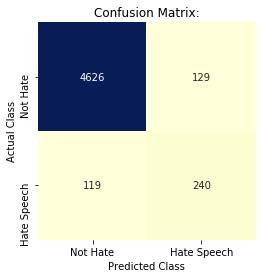

In [16]:
seaborn_confusion_matrix(y_val, lr_y_val_pred1)

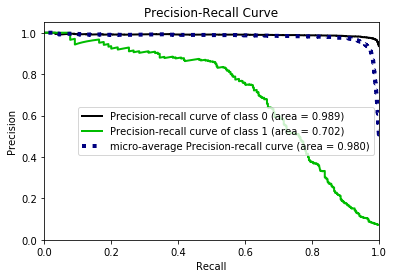

In [17]:
skplt.metrics.plot_precision_recall_curve(y_val, lr_y_val_prob1)

Adjusted Accuracy: 0.9579585451701212
Adjusted Precision: 0.7368421052631579
Adjusted Recall: 0.6239554317548747
Adjusted F1 Score: 0.6757164404223227




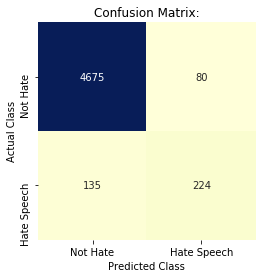

In [49]:
lr_val_y_adj, cm1 = adjust_threshold_and_score(y_val, lr_y_val_prob1, .20)

## Performance on Test Set:

In [20]:
logreg2, lr_X_test, lr_y_train_pred2, lr_y_test_pred, \
                lr_y_test_prob, logreg_metrics2, lr_pred_df2 = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet, y_test, 
                             LogisticRegression(C = 9, penalty = 'l1'), count_vect, sampling= 'upsample')

In [50]:
print_classification_report(y_test, lr_y_test_pred)

              precision    recall  f1-score   support

    not hate       0.97      0.98      0.98      5945
 hate speech       0.68      0.67      0.67       448

    accuracy                           0.95      6393
   macro avg       0.83      0.82      0.82      6393
weighted avg       0.95      0.95      0.95      6393



Adjusted Accuracy: 0.9583919912404192
Adjusted Precision: 0.7433155080213903
Adjusted Recall: 0.6205357142857143
Adjusted F1 Score: 0.6763990267639903




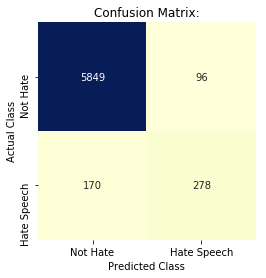

In [51]:
lr_test_y_adj, cm2 = adjust_threshold_and_score (y_test, lr_y_test_prob, .2)

### Exploring Misclassified Tweets in Test Set: 

In [53]:
lr_pred_df2['adjusted pred class'] = lr_test_y_adj

#### Predicted Class 1 (Hate Speech), Actual Class 0 (Not Hate Speech):

In [62]:
misclassified_as_hate = lr_pred_df2[(lr_pred_df2['adjusted pred class'] == 1) & (lr_pred_df2['actual class'] == 0)]
misclassified_as_hate.head()

,prob 0,prob 1,predicted class,actual class,adjusted pred class
3139,0.02,0.98,1,0,1
18929,0.06,0.94,1,0,1
5583,0.00,1.00,1,0,1
7966,0.02,0.98,1,0,1
20901,0.00,1.00,1,0,1


In [64]:
df['tweet'][3139]

'tdc media @user &amp; @user must be confused @user  of course it was a hate crime...a #radicalislamicterrorist attack against #usa'

In [66]:
df['tweet'][5583]

' @user if you do not suppo #equality, #womensrights, #reason, #education, #truth, #science, or critical thinking, then voteâ\x80¦'

#### Predicted Class 0 (Not Hate Speech), Actual Class 1 (Hate Speech):

In [61]:
misclassified_not_hate = lr_pred_df2[(lr_pred_df2['adjusted pred class'] == 0) & (lr_pred_df2['actual class'] == 1)]
misclassified_not_hate.head()

,prob 0,prob 1,predicted class,actual class,adjusted pred class
6161,0.99,0.01,0,1,0
30958,0.99,0.01,0,1,0
27842,1.00,0.00,0,1,0
16925,0.65,0.35,0,1,0
13437,1.00,0.00,0,1,0


In [68]:
df['tweet'][30958]

'@user everytime i wear soccer shis joie fries me and says i look mexican as fuck ð\x9f\x98\x92'

In [71]:
df['tweet'][13437]

'how many#pols passed by how many times and said nothing?   #bluelivesmatter #draintheswamp  #ferguson'